In [99]:
library(dplyr)
library(reshape2) 
library(tidyr)
library(plyr)
library(ggplot2)
library(ComplexHeatmap)

library("RColorBrewer")
library(wesanderson)
library(foreach)
library(circlize)
library(pals)
library(stringr)

library(viridis)
library(zoo)

library(tximportData)
library(tximport)
library('biomaRt')

library(DESeq2)

library(ggrepel)

In [3]:
ref_dir = '/home/chanj3/data/Prostate.LP.publication.010122/ref/'
out_dir = '/home/chanj3/data/Prostate.LP.publication.010122/out.human_organoid.010122/'


### Normalize RNA-seq

In [13]:
srr_df = c('MSKPCA1' = 'SRR15335220',
'MSKPCA2' = 'SRR15335221',
'MSKPCA3' = 'SRR15335222',
'MSKPCA6' = 'SRR15335225',
'MSKPCA8' = 'SRR15335227',
'MSKPCA11' = 'SRR15335230',
'MSKPCA12' = 'SRR15335231',
'MSKPCA16' = 'SRR15335235',
'WCM154' = 'SRR18026985',
'WCM155' = 'SRR18026986',
'LuCAP49' = 'SRR8528484',
'LuCAP176' = 'SRR8528515')

srr_df = data.frame(SRR = srr_df)

In [14]:
ifile = paste0(out_dir, 'human_organoid.metadata.final.txt')
df = read.table(ifile,sep='\t', row.names = 1, header=T)
df = df[rownames(srr_df),]

In [15]:
df$batch = gsub('[0-9]+','',rownames(df))

In [16]:
df$NEPC = df$Tang..et.al..subtype == 'NEPC'
df$WNT = df$Tang..et.al..subtype == 'Wnt'

In [17]:
fns = sapply(rownames(srr_df), function(x) sprintf('%skallisto/%s/abundance.h5', out_dir, x))

In [8]:
txi.kallisto <- tximport(fns, type = "kallisto", txOut = TRUE)


1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 




In [9]:
df

,Tang..et.al..subtype,Tissue,AR.status,JAK_STAT.signature,FGFR.signature,EMT.signature,Viability.after.Rux_Erda,AR.after.Rux_Erda,VIM.after.Rux_Erda,batch,NEPC,WNT
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
MSKPCA1,Wnt,Bone,AR-null,0.06835634,1.9367981,1.2561356,Decreased,0.00000000,-1.0439086,MSKPCA,FALSE,TRUE
MSKPCA2,AR-high,Bone,AR-high,-0.16932522,-1.1744594,-0.4283587,NA,NA,NA,MSKPCA,FALSE,FALSE
MSKPCA3,Stem-like,LN,AR-low,0.61096679,-0.6447303,0.5559110,No change,1.70639206,-2.9749293,MSKPCA,FALSE,FALSE
MSKPCA6,Stem-like,Prostate,AR-null,-2.53775805,-0.9991367,-1.8280254,No change,0.00000000,-3.2021205,MSKPCA,FALSE,FALSE
MSKPCA8,Stem-like,Bone,AR-low,0.94606984,0.4850357,1.0331534,No change,-0.00615388,0.0000000,MSKPCA,FALSE,FALSE
MSKPCA11,Stem-like,Liver,AR-low,0.98558158,0.1106119,1.1227254,No change,1.02212017,-0.9067406,MSKPCA,FALSE,FALSE
MSKPCA12,Stem-like,LN,AR-low,0.56391735,0.2588557,0.5957691,No change,0.69406075,-5.7839008,MSKPCA,FALSE,FALSE
MSKPCA16,Wnt,Liver,AR-null,0.44090926,1.7844987,-0.1401093,Decreased,0.00000000,-1.5304376,MSKPCA,FALSE,TRUE
WCM154,NEPC,Bone,AR-null,0.08569599,-0.2941126,-1.0655841,No change,0.00000000,0.0000000,WCM,TRUE,FALSE


In [10]:
dds <- DESeqDataSetFromTximport(txi.kallisto, df, ~batch + Tissue + NEPC + WNT)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport



In [11]:
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

In [12]:
dds <- DESeq(dds)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

1 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest



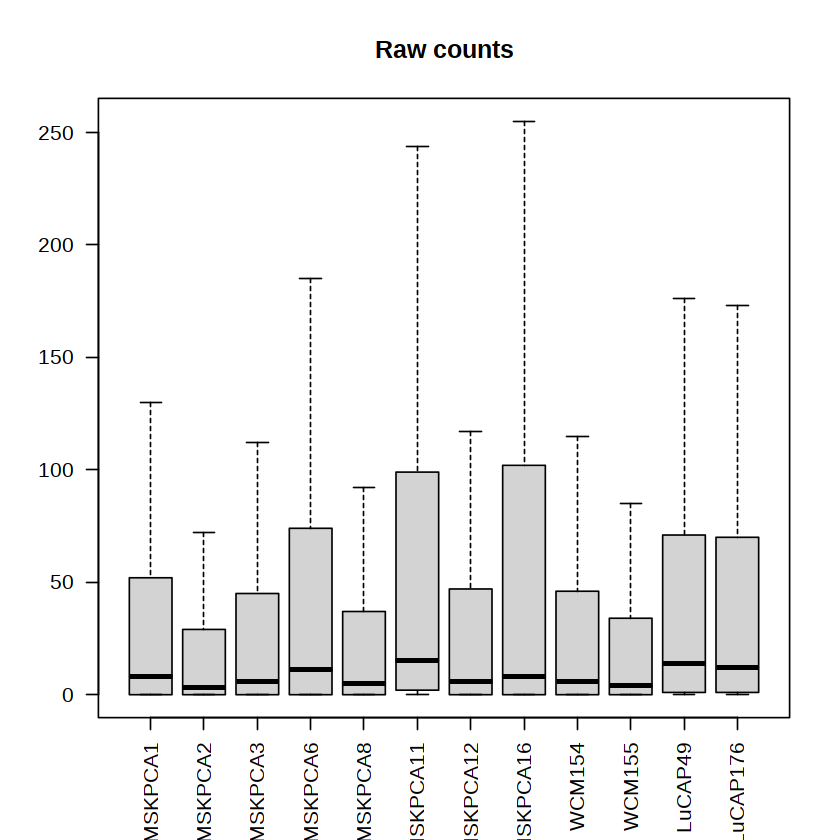

In [13]:
boxplot(assays(dds)[["counts"]], las=2, main='Raw counts', outline=F)

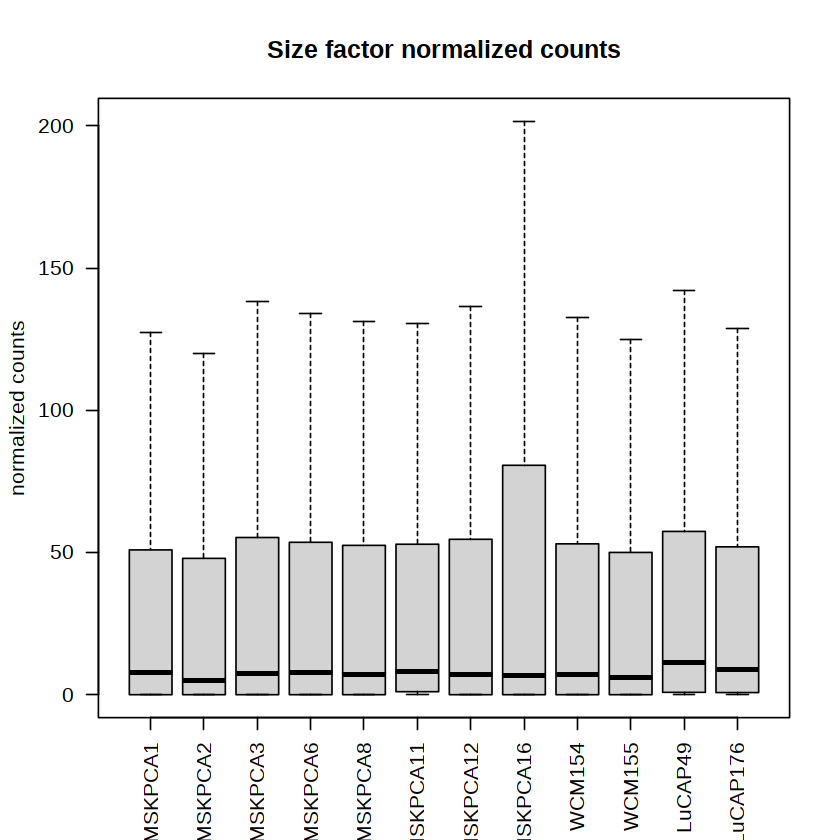

In [14]:
boxplot(counts(dds, normalized=TRUE), las=2, outline=F,main='Size factor normalized counts', ylab="normalized counts")

In [15]:
vsd <- vst(dds, blind = T)

In [16]:
mm <- model.matrix(~NEPC + WNT + AR.status, colData(vsd))


In [17]:
assay(vsd) <- limma::removeBatchEffect(x = assay(vsd), batch=vsd$batch, batch2=vsd$Tissue, design=mm)

Coefficients not estimable: batch23 


Warning message:
“Partial NA coefficients for 145075 probe(s)”


In [18]:
pca_mat = plotPCA(vsd, intgroup=c('Tang..et.al..subtype'), returnData = T)

In [19]:
pca_mat = pca_mat[,1:2]

In [20]:
plot_df = cbind(pca_mat, df)

In [21]:
plot_df$Tang..et.al..subtype = factor(plot_df$Tang..et.al..subtype)

In [22]:
plot_df$labels = rownames(plot_df)

In [23]:
library(repr)
options(repr.plot.width=7, repr.plot.height=5,
        ggrepel.max.overlaps = Inf)

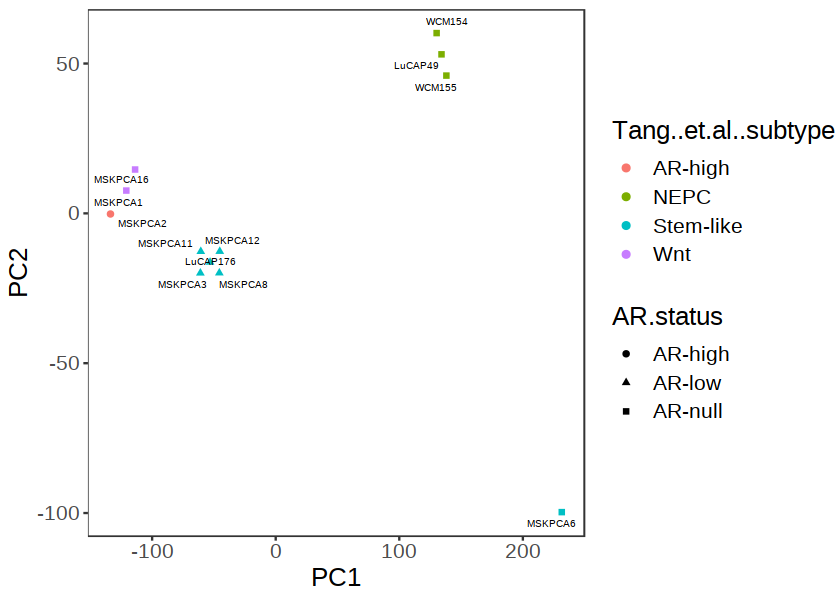

In [24]:
p = plot_df %>% ggplot(aes(x=PC1, y=PC2, label=labels)) + geom_point(aes(color = Tang..et.al..subtype, shape = AR.status)) +
    geom_text_repel(size=2) +     
    theme_bw() + theme(text = element_text(size=15),
                                                   plot.title = element_text(hjust = 0.5),
                                                   panel.grid.minor = element_blank(),
                                                  panel.grid.major = element_blank()) 
p

In [31]:
fig_dir = '/home/chanj3/data/SCPC_transformation.human_organoid.resubmission.010122/out.human_organoid.resubmission/figures/'

In [32]:
cairo_pdf(file = paste0(out_dir,'PCA.human_organoids.all.updated.060122.pdf'), width = 5, height = 3)

p

while (!is.null(dev.list()))  dev.off()


In [35]:
write.table(assay(vsd), paste0(out_dir, 'human_organoids.vst.expression.tissue_corrected.csv'), quote=F,sep=',')

### Get metadata

In [18]:
mut_mat = str_split(gsub('HET','DEL',df$P53.RB.PTEN.Mutational.Status),',')
mut_mat = do.call(rbind,mut_mat)
mut_mat = t(gsub('WT','',mut_mat))
rownames(mut_mat) = c('TP53','RB1','PTEN')
colnames(mut_mat) = rownames(df)

In [19]:
col_heat <- c('maroon','darkgreen')


In [20]:
alter_fun = list(
    background = function(x, y, w, h) {
        grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), gp = gpar(fill = "#CCCCCC", col = NA))
    },
    DEL = function(x, y, w, h) {
        grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), gp = gpar(fill = col_heat[1], col = NA))
    },
    MUT = function(x, y, w, h) {
        grid.rect(x, y, w-unit(0.5, "mm"), h*0.33, gp = gpar(fill = col_heat[2], col = NA))
    },   
    NONE = function(x, y, w, h) {
        grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), gp = gpar(fill = 'white', col = NA))
    }   
)

col = c("DEL" = col_heat[1],
        "MUT" = col_heat[2]
        )

col_desc = c("Deletion",
             "Mutation"
             )


In [21]:

mut_mat

,MSKPCA1,MSKPCA2,MSKPCA3,MSKPCA6,MSKPCA8,MSKPCA11,MSKPCA12,MSKPCA16,WCM154,WCM155,LuCAP49,LuCAP176
TP53,MUT,MUT,,,MUT,MUT/DEL,MUT,MUT,DEL,MUT,DEL,DEL
RB1,,,,DEL,MUT,,,,,,DEL,DEL
PTEN,DEL,DEL,DEL,DEL,DEL,DEL,,,,DEL,DEL,DEL


In [22]:
df

,Tang..et.al..subtype,Tissue,AR.status,JAK_STAT.signature,FGFR.signature,EMT.signature,Viability.after.Rux_Erda,AR.after.Rux_Erda,VIM.after.Rux_Erda,P53.RB.PTEN.Mutational.Status,batch,NEPC,WNT
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<lgl>
MSKPCA1,Wnt,Bone,AR-null,0.06835634,1.9367981,1.2561356,Decreased,0.00000000,-1.0439086,"MUT,WT,DEL",MSKPCA,FALSE,TRUE
MSKPCA2,AR-high,Bone,AR-high,-0.16932522,-1.1744594,-0.4283587,NA,NA,NA,"MUT,WT,DEL",MSKPCA,FALSE,FALSE
MSKPCA3,Stem-like,LN,AR-low,0.61096679,-0.6447303,0.5559110,No change,1.70639206,-2.9749293,"WT,WT,DEL",MSKPCA,FALSE,FALSE
MSKPCA6,Stem-like,Prostate,AR-null,-2.53775805,-0.9991367,-1.8280254,No change,0.00000000,-3.2021205,"WT,HET,DEL",MSKPCA,FALSE,FALSE
MSKPCA8,Stem-like,Bone,AR-low,0.94606984,0.4850357,1.0331534,No change,-0.00615388,0.0000000,"MUT,MUT,DEL",MSKPCA,FALSE,FALSE
MSKPCA11,Stem-like,Liver,AR-low,0.98558158,0.1106119,1.1227254,No change,1.02212017,-0.9067406,"MUT/DEL,WT,DEL",MSKPCA,FALSE,FALSE
MSKPCA12,Stem-like,LN,AR-low,0.56391735,0.2588557,0.5957691,No change,0.69406075,-5.7839008,"MUT,WT,WT",MSKPCA,FALSE,FALSE
MSKPCA16,Wnt,Liver,AR-null,0.44090926,1.7844987,-0.1401093,Decreased,0.00000000,-1.5304376,"MUT,WT,WT",MSKPCA,FALSE,TRUE
WCM154,NEPC,Bone,AR-null,0.08569599,-0.2941126,-1.0655841,No change,0.00000000,0.0000000,"DEL,WT,WT",WCM,TRUE,FALSE


In [44]:
df2 = data.frame(df) %>% dplyr::select(Tang..et.al..subtype,Tissue,AR.status,Viability.after.Rux_Erda)
colnames(df2) = c('Tang_etal_Subtype','Tissue','AR.status','Viability.change')

for (i in colnames(df2)) {
    df2[,i] = gsub(' \\(.*\\)','',df2[,i]) #str_to_title(df2[,i]))
}

In [45]:
df2$Tang_etal_Subtype = gsub('/.*','',df2$Tang_etal_Subtype)
df2$Tang_etal_Subtype = factor(df2$Tang_etal_Subtype, levels=c('AR-high', 'Stem-like','Wnt','NEPC'))

In [46]:
df2$AR.status = factor(df2$AR.status, levels=c('AR-null', 'AR-low','AR-high'))

In [47]:
df2$Viability.change = factor(df2$Viability.change, levels=c('No change', 'Decreased'))

In [80]:
df2 = df2 %>% dplyr::arrange(Tang_etal_Subtype,desc(AR.status), desc(Viability.change))

In [82]:
mut_mat2 = mut_mat[,rownames(df2)]


In [83]:
fc_mat = df %>% dplyr::select(AR.after.Rux_Erda,VIM.after.Rux_Erda)
colnames(fc_mat) = c('AR','VIM')

In [84]:
fc_mat[is.na(fc_mat)] = 0


In [85]:
df3 = cbind(df2, fc_mat[rownames(df2),])

In [86]:
df3 = df3 %>% dplyr::arrange(Tang_etal_Subtype,desc(AR.status), desc(AR), VIM)

In [87]:
df3

,Tang_etal_Subtype,Tissue,AR.status,Viability.change,AR,VIM
,<fct>,<chr>,<fct>,<fct>,<dbl>,<dbl>
MSKPCA2,AR-high,Bone,AR-high,NA,0.00000000,0.0000000
MSKPCA3,Stem-like,LN,AR-low,No change,1.70639206,-2.9749293
LuCAP176,Stem-like,Liver,AR-low,No change,1.16557509,0.0000000
MSKPCA11,Stem-like,Liver,AR-low,No change,1.02212017,-0.9067406
MSKPCA12,Stem-like,LN,AR-low,No change,0.69406075,-5.7839008
MSKPCA8,Stem-like,Bone,AR-low,No change,-0.00615388,0.0000000
MSKPCA6,Stem-like,Prostate,AR-null,No change,0.00000000,-3.2021205
MSKPCA16,Wnt,Liver,AR-null,Decreased,0.00000000,-1.5304376
MSKPCA1,Wnt,Bone,AR-null,Decreased,0.00000000,-1.0439086


In [88]:
mut_mat3 = mut_mat2[,rownames(df3)]

### Gene signatures

In [94]:
jak_stat = c('IRF9',
'STAT1',
'STAT2',
'CCND3',
'STAT3',
'IL13RA1',
'IL11RA1',
'AKT3',
'SPRED1',
'IL10RB',
'CCND1',
'PIK3R1',
'SOCS2',
'SPRY1',
'JAK1',
'PIK3R2',
'IFNAR1',
'STAM',
'STAT5B',
'PIAS2',
'AKT2',
'PTPN11',
'STAT5A',
'JUN',
'CXCL10',
'CD44',
'CXCL2',
'TNF',
'CD14',
'TNFRSF1B',
'BAK1',
'IRF1',
'CSF1')

In [95]:
fgfr = c('FGF1',
'FGF10',
'FGF17',
'FGF18',
'FGF19',
'FGF2',
'FGF20',
'FGF22',
'FGF23',
'FGF3',
'FGF4',
'FGF5',
'FGF6',
'FGF7',
'FGF8',
'FGF9',
'FGFR1',
'DUSP6',
'TGIF',
'SMAD3',
'SMAD2',
'THBS1',
'FOS',
'TGFBR2',
'SOX9',
'TGFB1',
'FKBP1A',
'MMP15',
'FGFR2',
'FGFR3')

In [96]:
AR = c('FKBP5',
'KLK2',
'ELL2',
'TMPRSS2',
'ZBTB10',
'CENPN',
'PMEPA1',
'NKX3-1 ',
'KLK3',
'EAF2',
'MED28',
'ABCC4',
'SARG',
'GNMT',
'MPHOSPH9 ',
'NNMT',
'ADAM7',
'TNK1',
'MAN1A1',
'GLRA2',
'CD200',
'MAPRE2',
'PIP4K2B',
'AR',
'SRP72',
'TBC1D9B',
'ACSL3',
'MAF',
'HERC3',
'PTGER4')

In [97]:
EMT = c('COL3A1',
'COL5A2',
'COL5A1',
'FBN1',
'COL1A1',
'FN1',
'COL6A3',
'SERPINE1',
'COL1A2',
'COL4A1',
'COL4A2',
'VCAN',
'IGFBP3  ',
'TGFBI',
'SPARC',
'LUM',
'LAMC1',
'LOX',
'LAMC2',
'CTGF',
'TAGLN',
'COL7A1',
'LOXL2',
'COL6A2',
'ITGAV',
'THBS2',
'COL16A1',
'NNMTCDH2',
'MMP2',
'COL11A1',
'THBS1',
'FAP',
'BGN',
'SERPINH1',
'FSTL1',
'POSTN',
'THY1',
'SPP1',
'TNC',
'TFPI2',
'NID2',
'ITGB5',
'MMP3',
'VIM',
'LOXL1',
'FBLN5',
'COL12A1',
'CDH11',
'COMP',
'SPOCK1',
'BMP1',
'LAMA3',
'TIMP1',
'QSOX1',
'TIMP3',
'VCAM1',
'CYR61',
'EDIL3',
'MAGEE1',
'FBLN1',
'SGCB',
'ECM1',
'LAMA2',
'FSTL3',
'INHBA',
'DAB2',
'EMP3',
'BASP1',
'ITGA5',
'MGP',
'VEGFA',
'WNT5A',
'SDC1',
'PLOD2',
'PCOLCE',
'GREM1',
'ITGB1',
'COL5A3',
'RHOB',
'HTRA1',
'FGF2',
'SNTB1',
'GADD45A',
'MEST',
'LRRC15',
'TNFRSF11B',
'CD59B',
'ACTA2',
'EFEMP2',
'MATN2',
'PCOLCE2',
'SERPINE2',
'GPC1',
'FUCA1',
'SLIT3',
'LAMA1',
'PMEPA1',
'COL8A2',
'FBN2',
'IGFBP2',
'PFN2SDC4',
'CD44',
'GADD45B',
'GLIPR1',
'ANPEP',
'LEPRE1',
'VEGFC',
'MMP14',
'SGCD',
'PLOD1',
'MATN3',
'MYL9',
'SLC6A8',
'CALU',
'PRRX1',
'TNFRSF12A',
'FMOD',
'ID2',
'GEM',
'PLAUR',
'MYLK',
'TGFB1',
'SFRP1',
'PLOD3',
'IL6',
'APLP1',
'FBLN2',
'MSX1',
'PTX3',
'FZD8',
'JUNFERMT2',
'DKK1',
'SNAI2',
'DCN',
'GJA1',
'PMP22',
'IGFBP4',
'COPA',
'LRP1',
'ITGA2',
'FLNA',
'MFAP5',
'PTHLH',
'TGFBR3',
'SFRP4',
'LGALS1',
'RGS4',
'CDH6',
'SAT1',
'NT5E',
'DPYSL3',
'PPIB',
'TGM2',
'SGCG',
'ITGB3',
'PDLIM4',
'CTHRC1',
'ECM2',
'CRLF1',
'AREG',
'IL15MCM7',
'GAS1',
'PRSS2',
'CADM1',
'OXTR',
'SCG2',
'CXCL5',
'MMP1A',
'TNFAIP3',
'CAPG',
'CAP2',
'FOXC2',
'NTM',
'ENO2',
'FAS',
'BDNFADAM12',
'CXCL12',
'PDGFRB',
'SLIT2',
'NOTCH2',
'GPX7',
'WIPF1')

### Add gene signatures

In [98]:
mat = as.matrix(read.table(paste0(out_dir, 'human_organoids.vst.expression.tissue_corrected.csv'), sep=','))

In [101]:
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))

In [102]:
G_list <- getBM(filters= "ensembl_transcript_id", attributes= c("ensembl_transcript_id","hgnc_symbol"),
                values=gsub('\\.[0-9]+$','',rownames(mat)),
                mart= mart)


In [103]:
ord = match(gsub('.[0-9]+$','',rownames(mat)), G_list$ensembl_transcript_id)


In [104]:
genes = G_list[ord,'hgnc_symbol']

In [139]:
mat2 = mat[genes %in% c(jak_stat, fgfr, EMT),]

In [140]:
ord = match(gsub('.[0-9]+$','',rownames(mat2)), G_list$ensembl_transcript_id)
genes2 = G_list[ord,'hgnc_symbol']


In [141]:
mat2 = aggregate(mat2, list(genes2), mean)
rownames(mat2) = mat2[,1]
mat2 = mat2[,2:ncol(mat2)]

In [142]:
mat3 = t(scale(t(mat2)))

In [143]:
genes3 = rownames(mat3)

In [144]:
jak_stat_score = scale(colMeans(mat2[genes3 %in% jak_stat,]))
fgfr_score = scale(colMeans(mat2[genes3 %in% fgfr,]))
emt_score = scale(colMeans(mat2[genes3 %in% EMT,]))


In [145]:
ord = match(rownames(df3), colnames(mat2))

In [146]:
df5 = df3
df5$JAK_STAT = jak_stat_score[ord]
df5$FGFR = fgfr_score[ord]
df5$EMT = emt_score[ord]


In [147]:
df5

,Tang_etal_Subtype,Tissue,AR.status,Viability.change,AR,VIM,JAK_STAT,FGFR,EMT
,<fct>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MSKPCA2,AR-high,Bone,AR-high,NA,0.00000000,0.0000000,-0.8414071,-2.10776583,-2.17425960
MSKPCA3,Stem-like,LN,AR-low,No change,1.70639206,-2.9749293,0.8696611,-0.70113345,-0.50747688
LuCAP176,Stem-like,Liver,AR-low,No change,1.16557509,0.0000000,0.8383315,-0.16442300,0.01582132
MSKPCA11,Stem-like,Liver,AR-low,No change,1.02212017,-0.9067406,1.0326157,-0.19248831,0.34405789
MSKPCA12,Stem-like,LN,AR-low,No change,0.69406075,-5.7839008,0.8070019,0.37228745,0.53911951
MSKPCA8,Stem-like,Bone,AR-low,No change,-0.00615388,0.0000000,0.6440473,-0.13635769,-0.31241526
MSKPCA6,Stem-like,Prostate,AR-null,No change,0.00000000,-3.2021205,-2.3158862,0.04385275,0.99153829
MSKPCA16,Wnt,Liver,AR-null,Decreased,0.00000000,-1.5304376,0.3072351,1.79601643,-1.24082441
MSKPCA1,Wnt,Bone,AR-null,Decreased,0.00000000,-1.0439086,-0.5248689,1.58827295,-0.51230813


In [148]:
viability_mat = t(matrix(as.numeric(df5$Viability.change == 'Yes')))
colnames(viability_mat) = rownames(df5)
rownames(viability_mat) = c('Viability.change')

In [149]:
sig_mat = cbind(jak_stat_score, fgfr_score, emt_score)[rownames(df5),] #, nepc_score)[rownames(df5),]
colnames(sig_mat) = c('JAK/STAT','FGFR','EMT') #,'NEPC')

In [150]:
df5 = df5 %>% dplyr::rename(`Tang, et al. subtype` = Tang_etal_Subtype, `AR status` = AR.status,
                               Viability = Viability.change)

In [151]:
ha_df = df5 %>% dplyr::select(-AR, -VIM, -EMT, -JAK_STAT, -FGFR, -Tissue, Viability)

In [152]:
col_subtype = brewer.pal(n=length(unique(df2$Tang_etal_Subtype)), name="Pastel1")
names(col_subtype) = sort(unique(df2$Tang_etal_Subtype))

col_ar = c('lightgray','royalblue1', 'blue3')
names(col_ar) = sort(unique(df2$AR.status))

col_viability = c('lightgray','lightslateblue')
names(col_viability) = sort(unique(df2$Viability.change))

col_list = list()
col_list[['Tang, et al. subtype']] = col_subtype
col_list[['AR status']] = col_ar
col_list[['Viability']] = col_viability


In [153]:
library(repr)
options(repr.plot.width=8, repr.plot.height=8)

All mutation types: MUT, DEL.

`alter_fun` is assumed vectorizable. If it does not generate correct
plot, please set `alter_fun_is_vectorized = FALSE` in `oncoPrint()`.



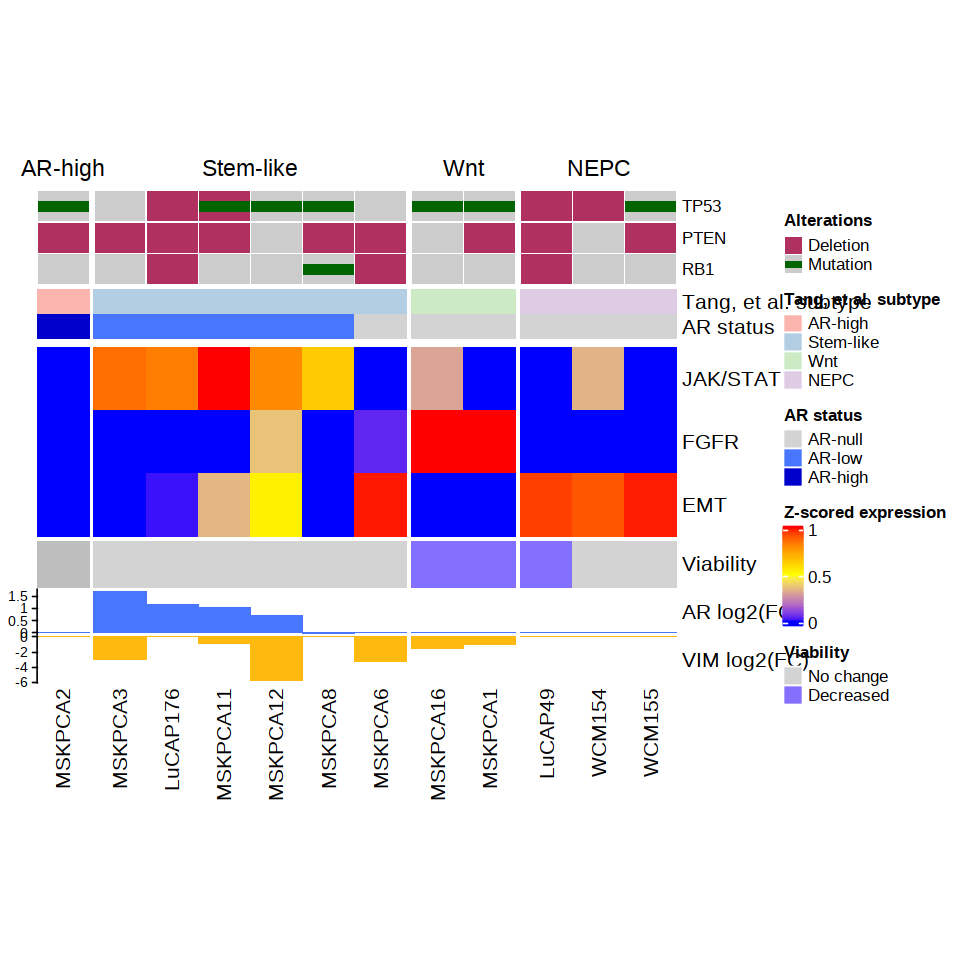

In [158]:
# Batch corrected tissue
ha = HeatmapAnnotation(df = ha_df %>% dplyr::select(-Viability), 
                   col = col_list,
                   annotation_height=0.01
                       )

ha2 = HeatmapAnnotation( 
    df = ha_df %>% dplyr::select(-`Tang, et al. subtype`, -`AR status`), 
                       col = col_list,
                       annotation_height=0.01,
    `AR log2(FC)` = anno_barplot(as.data.frame(df5) %>% dplyr::select(AR), bar_width = 1, 
                                       gp = gpar(col = NA, fill = "royalblue1"), border = FALSE, axis = TRUE),
    `VIM log2(FC)` = anno_barplot(as.data.frame(df5) %>% dplyr::select(VIM), bar_width = 1, 
                                        gp = gpar(col = NA, fill = "darkgoldenrod1"), border = FALSE, axis = TRUE),
    height = unit(3, "cm")
                      )

ht1 = oncoPrint( mut_mat3 , get_type = function(x) strsplit(x, "/")[[1]],
    alter_fun = alter_fun, col = col, 
    #column_title = "Genotype",
    top_annotation = NULL,
    bottom_annotation = ha,
    right_annotation = NULL, 
    column_order = 1:ncol(mut_mat2),
    column_split = df5$`Tang, et al. subtype`,
    show_column_names = T,
    show_pct = F,
    height = unit(2, "cm"),
    heatmap_legend_param = list(title = "Alterations", at = names(col), 
        labels = col_desc))

ht2 = Heatmap(t(sig_mat), name = "Z-scored expression", 
              col=  colorRamp2(c(0, 0.5, 1), c("blue", "yellow", "red")),
              cluster_rows = FALSE, cluster_columns = FALSE,
              top_annotation = NULL, 
              bottom_annotation = ha2,
              height = unit(4, "cm"), 
    show_heatmap_legend = T) #

ht1 %v% ht2


In [159]:
fig_dir = '/home/chanj3/data/SCPC_transformation.human_organoid.resubmission.010122/out.human_organoid.resubmission/figures/'

In [161]:
cairo_pdf(file = paste0(fig_dir,'human_organoid.attribute_matrix.gene_signatures.tissue_corrected.updated.060122.pdf'), width = 8, height = 7)

ht1 %v% ht2

while (!is.null(dev.list()))  dev.off()
